# Imports

In [6]:
import pandas as pd
import numpy as np
import category_encoders as ce
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
import seaborn as sns
%matplotlib inline 

# Leitura do dataset

In [2]:
data = pd.read_excel("data20-2_ate_23-2_sem_nulos_190.xlsx")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190798 entries, 0 to 190797
Data columns (total 49 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Data de cadastro                    190798 non-null  object
 1   Canal de atendimento                190798 non-null  object
 2   Denúncia emergencial                190798 non-null  object
 3   Denunciante                         190798 non-null  object
 4   Cenário da violação                 190798 non-null  object
 5   País                                190798 non-null  object
 6   UF                                  190798 non-null  object
 7   Município                           190798 non-null  object
 8   Frequência                          190798 non-null  object
 9   Início das violações                190798 non-null  object
 10  sl quantidade vitimas               190798 non-null  int64 
 11  Motivações                          190

In [4]:
data.head()

,Data de cadastro,Canal de atendimento,Denúncia emergencial,Denunciante,Cenário da violação,País,UF,Município,Frequência,Início das violações,...,sl suspeito naturalizado municipio,Deficiência do suspeito,Doença rara do suspeito,Suspeito preso,País do suspeito,UF do suspeito,Município do suspeito,Profissão do suspeito,Raça\Cor do suspeito,Violações
0,2020-07-03 20:14:07,TELEFONICO,NAO,TERCEIRO,CASA DA VITIMA,BRASIL,DF,BRASILIA,SEMANALMENTE,HA MAIS DE UM ANO,...,Nao Informado,NAO TEM DEFICIENCIA,NAO TEM DOENCA RARA,Nao Informado,BRASIL,DF,BRASILIA,OUTROS,BRANCA,INTEGRIDADE>PSIQUICA>AMEACA OU COACAO
1,2020-07-05 02:31:55,TELEFONICO,NAO,ANONIMO,CASA DE TERCEIRO,BRASIL,PB,JOAO PESSOA,DIARIAMENTE,HA UM MES,...,Nao Informado,NAO TEM DEFICIENCIA,NAO TEM DOENCA RARA,Nao Informado,BRASIL,PB,JOAO PESSOA,OUTROS,Nao Informado,INTEGRIDADE>PSIQUICA>AMEACA OU COACAO
2,2020-07-06 12:53:02,TELEFONICO,NAO,A PROPRIA VITIMA,CASA DA VITIMA,BRASIL,SP,RIBEIRAO PRETO,OCASIONALMENTE,HA UM MES,...,Nao Informado,NAO TEM DEFICIENCIA,NAO TEM DOENCA RARA,Nao Informado,BRASIL,SP,RIBEIRAO PRETO,OUTROS,BRANCA,INTEGRIDADE>PSIQUICA>AMEACA OU COACAO
3,2020-07-10 00:00:09,TELEFONICO,NAO,ANONIMO,OUTROS,BRASIL,ES,MIMOSO DO SUL,DIARIAMENTE,HA UM MES,...,Nao Informado,NAO TEM DEFICIENCIA,NAO TEM DOENCA RARA,Nao Informado,BRASIL,ES,MIMOSO DO SUL,OUTROS,Nao Informado,INTEGRIDADE>PSIQUICA>CONSTRANGIMENTO
4,2020-07-03 00:39:21,TELEFONICO,NAO,A PROPRIA VITIMA,CASA DA VITIMA,BRASIL,RS,PORTO ALEGRE,UNICA OCORRENCIA,NAO SE APLICA,...,Nao Informado,NAO TEM DEFICIENCIA,NAO TEM DOENCA RARA,NAO,BRASIL,RS,PORTO ALEGRE,OUTROS,PARDA,LIBERDADE>SEXUAL>FISICA>ESTUPRO


## Criando datasets de vitima e suspeito

In [14]:

# Supondo que seu DataFrame se chame 'df'
df_columns = data.columns

# Listas para armazenar as colunas separadas
vítima_columns = []
suspeito_columns = []
neutras_columns = []

# Separando as colunas
for column in df_columns:
    if 'vítima' in column.lower():
        vítima_columns.append(column)
    elif 'suspeito' in column.lower():
        suspeito_columns.append(column)
    else:
        neutras_columns.append(column)

# Adicionando as colunas neutras em ambos os grupos
vítima_columns.extend(neutras_columns)
suspeito_columns.extend(neutras_columns)

# Criando os DataFrames separados
df_vitima = data[vítima_columns]
df_suspeito = data[suspeito_columns]

# Remover as colunas 31, 30, 29 e 28 pq o REGEX ta bugado por causa do "sl"
df_suspeito = df_suspeito.drop(columns=['sl vitima naturalizado municipio', 'sl vitima naturalizado uf', 'sl vitima naturalidade', 'sl vitima cadastro'])

# Visualizando as colunas separadas
#print("Colunas relacionadas à vítima:", vítima_columns)
#print("Colunas relacionadas ao suspeito:", suspeito_columns)
print(f"Colunas neutras: {neutras_columns}")

Colunas neutras: ['Data de cadastro', 'Canal de atendimento', 'Denúncia emergencial', 'Denunciante', 'Cenário da violação', 'País', 'UF', 'Município', 'Frequência', 'Início das violações', 'sl quantidade vitimas', 'Motivações', 'sl vitima cadastro', 'sl vitima naturalidade', 'sl vitima naturalizado uf', 'sl vitima naturalizado municipio', 'Violações']


In [15]:
df_vitima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190798 entries, 0 to 190797
Data columns (total 33 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   Relação vítima-suspeito           190798 non-null  object
 1   Sexo da vítima                    190798 non-null  object
 2   Orientação sexual da vítima       190798 non-null  object
 3   Faixa etária da vítima            190798 non-null  object
 4   Nacionalidade da vítima           190798 non-null  object
 5   Deficiência da vítima             190798 non-null  object
 6   Doença rara da vítima             190798 non-null  object
 7   Vítima preso(a)                   190798 non-null  object
 8   País da vítima                    190798 non-null  object
 9   UF da vítima                      190798 non-null  object
 10  Município da vítima               190798 non-null  object
 11  Profissão da vítima               190798 non-null  object
 12  Gr

In [16]:
df_suspeito.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190798 entries, 0 to 190797
Data columns (total 29 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Natureza Jurídica do Suspeito       190798 non-null  object
 1   Sexo do suspeito                    190798 non-null  object
 2   Orientação sexual do suspeito       190798 non-null  object
 3   Faixa etária do suspeito            190798 non-null  object
 4   Nacionalidade do suspeito           190798 non-null  object
 5   sl suspeito naturalidade            190798 non-null  object
 6   sl suspeito naturalizado uf         190798 non-null  object
 7   sl suspeito naturalizado municipio  190798 non-null  object
 8   Deficiência do suspeito             190798 non-null  object
 9   Doença rara do suspeito             190798 non-null  object
 10  Suspeito preso                      190798 non-null  object
 11  País do suspeito                    190

# K-Modes

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2331295.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 2331295.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 2331295.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 2331295.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 2331295.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 79736, cost: 2175379.0
Run 1, iteration: 2/100, moves: 16098, cost: 2171582.0
Run 1, iteration: 3/100, moves: 67, cost: 2171582.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
R

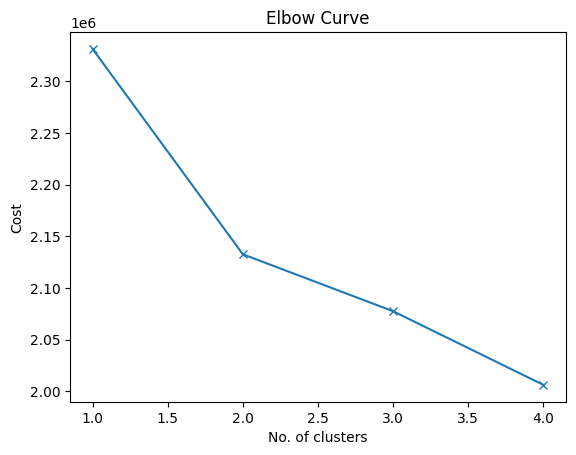

In [17]:
from kmodes.kmodes import KModes 
import matplotlib.pyplot as plt 
%matplotlib inline 

# Elbow curve to find optimal K 
cost = [] 
K = range(1,5) 
for k in list(K): 
	kmode = KModes(n_clusters=k, init = "random", n_init = 5, verbose=1) 
	kmode.fit_predict(df_suspeito) 
	cost.append(kmode.cost_) 
	
plt.plot(K, cost, 'x-') 
plt.xlabel('No. of clusters') 
plt.ylabel('Cost') 
plt.title('Elbow Curve') 
plt.show()
